# Recurrent Neural Network

### Q1
Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current
year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model
for the dataset 
https://datahub.io/core/natural-gas#resource-daily or
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices
Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict
the price for the 11th day

Epoch 0, Loss: 0.10518
Epoch 50, Loss: 0.01000
Epoch 100, Loss: 0.00344
Epoch 150, Loss: 0.00102
Epoch 200, Loss: 0.00025
Epoch 250, Loss: 0.00035
Epoch 300, Loss: 0.00030
Epoch 350, Loss: 0.00032
Epoch 400, Loss: 0.00036
Epoch 450, Loss: 0.00024
Epoch 500, Loss: 0.00028
Epoch 550, Loss: 0.00024
Epoch 600, Loss: 0.00017
Epoch 650, Loss: 0.00022
Epoch 700, Loss: 0.00017
Epoch 750, Loss: 0.00059
Epoch 800, Loss: 0.00018
Epoch 850, Loss: 0.00041
Epoch 900, Loss: 0.00016
Epoch 950, Loss: 0.00016
Epoch 1000, Loss: 0.00015
Epoch 1050, Loss: 0.00012
Epoch 1100, Loss: 0.00014
Epoch 1150, Loss: 0.00108
Epoch 1200, Loss: 0.00017
Epoch 1250, Loss: 0.00012
Epoch 1300, Loss: 0.00013
Epoch 1350, Loss: 0.00103
Epoch 1400, Loss: 0.00030
Epoch 1450, Loss: 0.00013


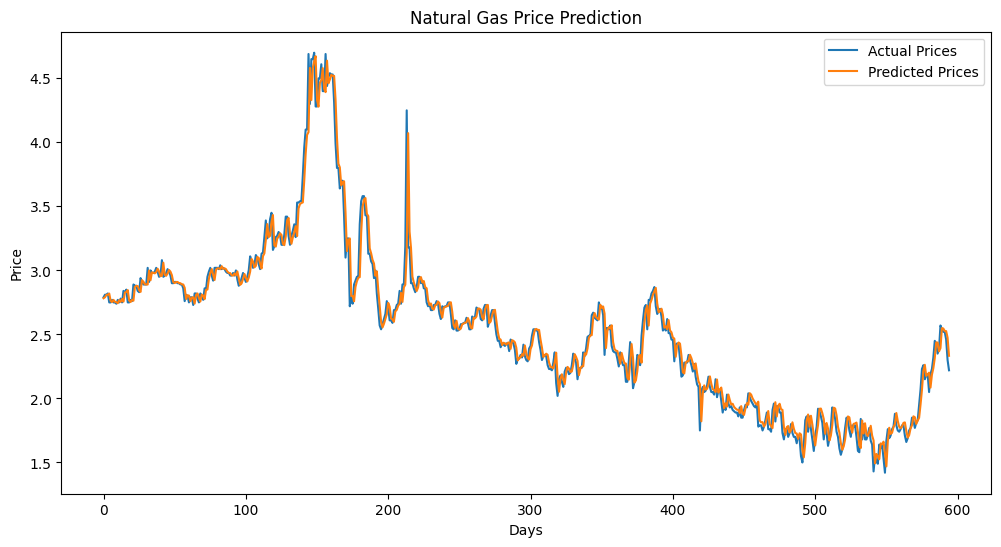

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn


df = pd.read_csv("../data/natural_gas_prices/daily.csv")
df = df.dropna()
prices = df['Price'].values

min_price = prices.min()
max_price = prices.max()
normalized_prices = (prices - min_price) / (max_price - min_price)

sequence_length = 10
X, y = [], []
for i in range(len(normalized_prices) - sequence_length):
    X.append(normalized_prices[i:i+sequence_length])
    y.append(normalized_prices[i+sequence_length])

X = np.array(X)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

class GasDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = GasDataset(x_train, y_train)
test_dataset = GasDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

class GasPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1, hidden_size=5, num_layers=1, batch_first=True
        )
        self.fc = nn.Linear(5, 1)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

model = GasPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1500
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")


model.eval()
with torch.no_grad():
    test_inputs, test_targets = next(iter(test_loader))
    test_preds = model(test_inputs)
    
    test_preds = test_preds.numpy() * (max_price - min_price) + min_price
    test_targets = test_targets.numpy() * (max_price - min_price) + min_price

    plt.figure(figsize=(12,6))
    plt.plot(test_targets, label='Actual Prices')
    plt.plot(test_preds, label='Predicted Prices')
    plt.title('Natural Gas Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


### Q2
The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a RNN on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling

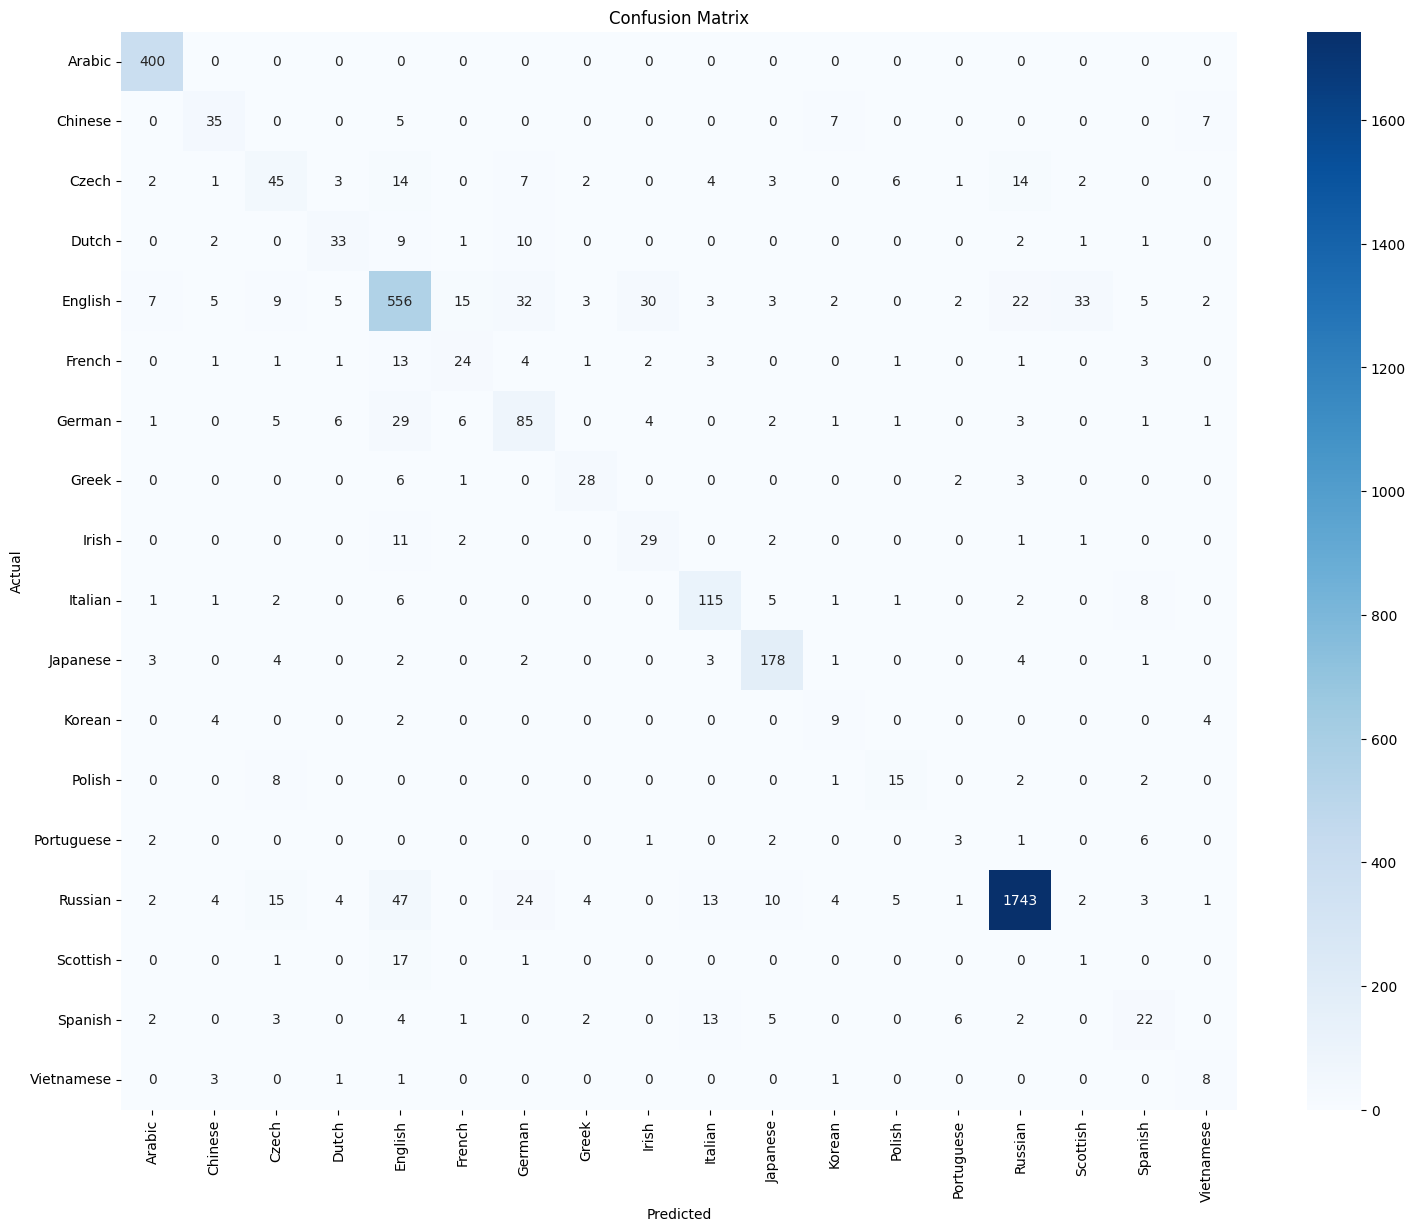

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(42)
np.random.seed(42)

DATA_DIR = os.path.join("..", "data", "names", "names")

def load_data():
    languages, names = [], []
    for filename in os.listdir(DATA_DIR):
        if filename.endswith(".txt"):
            lang = filename.split(".")[0]
            with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
                lang_names = f.read().strip().split('\n')
                languages.extend([lang] * len(lang_names))
                names.extend(lang_names)
    return names, languages

names, languages = load_data()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(languages)
num_classes = len(label_encoder.classes_)

all_chars = set(''.join(names))
char_to_idx = {'<PAD>': 0, '<UNK>': 1}
for i, char in enumerate(sorted(all_chars), 2):
    char_to_idx[char] = i
vocab_size = len(char_to_idx)

class NameDataset(Dataset):
    def __init__(self, names, labels):
        self.names = names
        self.labels = labels
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        indices = [char_to_idx.get(c, 1) for c in name]
        return torch.tensor(indices, dtype=torch.long), self.labels[idx]

X_train, X_test, y_train, y_test = train_test_split(
    names, labels, test_size=0.2, stratify=labels, random_state=42
)

class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def collate_fn(batch):
    names, labels = zip(*batch)
    lengths = torch.tensor([len(name) for name in names])
    padded = nn.utils.rnn.pad_sequence(names, batch_first=True, padding_value=0)
    return padded, lengths, torch.tensor(labels, dtype=torch.long)

train_dataset = NameDataset(X_train, y_train)
test_dataset = NameDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset, batch_size=128, sampler=sampler, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=256, collate_fn=collate_fn
)

class NameClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.rnn = nn.GRU(128, 256, bidirectional=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, hidden = self.rnn(packed)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(hidden)

model = NameClassifier(vocab_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

def train_model(epochs=50):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for inputs, lengths, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        acc = evaluate_model()
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_model.pth')
            
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

def evaluate_model():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, lengths, labels in test_loader:
            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_model()

def plot_confusion_matrix():
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, lengths, labels in test_loader:
            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(18, 14))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def analyze_errors():
    model.eval()
    errors = []
    
    with torch.no_grad():
        for i in range(len(test_dataset)):
            name = X_test[i]
            label = y_test[i]
            tensor_name, length = test_dataset[i][0], len(test_dataset[i][0])
            output = model(tensor_name.unsqueeze(0), torch.tensor([length]))
            _, pred = torch.max(output, 1)
            
            if pred.item() != label:
                errors.append((
                    name,
                    label_encoder.inverse_transform([label])[0],
                    label_encoder.inverse_transform([pred.item()])[0]
                ))


plot_confusion_matrix()
analyze_errors()

def predict_language(name):
    model.eval()
    with torch.no_grad():
        indices = [char_to_idx.get(c, 1) for c in name]
        tensor = torch.tensor(indices).unsqueeze(0)
        length = torch.tensor([len(indices)])
        output = model(tensor, length)
        _, pred = torch.max(output, 1)
        return label_encoder.inverse_transform([pred.item()])[0]


### Q3
Implement a next character predictor using RNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

class Config:
    text = "hello world, this is a character-level RNN example."
    seq_length = 10
    batch_size = 32
    embedding_dim = 64
    hidden_size = 128
    num_layers = 2
    dropout = 0.2
    learning_rate = 0.001
    num_epochs = 500
    temperature = 0.5

chars = sorted(list(set(Config.text)))
char_to_idx = {c:i for i, c in enumerate(chars)}
idx_to_char = {i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

encoded = [char_to_idx[c] for c in Config.text]

class CharDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+self.seq_length], dtype=torch.long)
        return x, y

dataset = CharDataset(encoded, Config.seq_length)
dataloader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

class CharRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, Config.embedding_dim)
        self.rnn = nn.GRU(Config.embedding_dim, Config.hidden_size, 
                         num_layers=Config.num_layers, 
                         dropout=Config.dropout,
                         batch_first=True)
        self.fc = nn.Linear(Config.hidden_size, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

model = CharRNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate)

for epoch in range(Config.num_epochs):
    model.train()
    total_loss = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch+1) % 50 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{Config.num_epochs} | Loss: {avg_loss:.4f}")

def generate_text(model, seed, length=100):
    model.eval()
    device = next(model.parameters()).device
    generated = list(seed)
    
    h = torch.zeros(Config.num_layers, 1, Config.hidden_size).to(device)
    
    for _ in range(length):
        input_seq = generated[-Config.seq_length:]
        x = torch.tensor([char_to_idx[c] for c in input_seq], 
                        dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output, h = model(x, h)
            
        probs = F.softmax(output / Config.temperature, dim=1).cpu()
        next_char = torch.multinomial(probs, num_samples=1).item()
        
        generated.append(idx_to_char[next_char])
    
    return ''.join(generated)

seed = "hello wor"
generated = generate_text(model, seed, length=100)
print(f"\nGenerated text:\n{generated}")


Epoch 50/500 | Loss: 0.2469
Epoch 100/500 | Loss: 0.0250
Epoch 150/500 | Loss: 0.0120
Epoch 200/500 | Loss: 0.0067
Epoch 250/500 | Loss: 0.0047
Epoch 300/500 | Loss: 0.0036
Epoch 350/500 | Loss: 0.0025
Epoch 400/500 | Loss: 0.0020
Epoch 450/500 | Loss: 0.0016
Epoch 500/500 | Loss: 0.0013

Generated text:
hello word, this is a character-level RNN example... RNN example... RNN example... RNN example... RNN example
